In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_theme(font='Times New Roman', font_scale=1.2)
plt.rc("figure", autolayout=True)
# plot settings
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.grid'] = False
# Chinese support
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [40]:
df = pd.read_csv('./waveform.data', header=None)
print(df[21].value_counts())
df.head()

2    1696
0    1657
1    1647
Name: 21, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1


## PAM 算法聚类

In [41]:
def add_noise(data): # 20% 加高斯噪声
    numSamples, dim = data.shape
    sample = set((numSamples * 
                  np.random.rand(int(numSamples * 0.2))).astype(int))
    for i in sample:
        for j in range(dim):
            data[i, j] += random.gauss(mu=0, sigma=1)
    return data

In [42]:
data = df.iloc[:, 0:21].to_numpy()
data = add_noise(data)

In [43]:
def calDist(vec1, vec2):
    distance = np.sqrt(np.sum(np.square(vec2 - vec1)))
    return distance

In [44]:
def PAM(dataSet, k):
    numSamples, dim = dataSet.shape
    newdata = copy.deepcopy(dataSet)
    nowdata = copy.deepcopy(dataSet)
    cid = np.random.choice(numSamples, k, replace=False)
    centroids = newdata[cid, :dim-1]
    dist = [[] for  i in range(k)]
    newdist = [[] for i in range(k)]
    lost = np.ones([numSamples, k]) * float('inf')
    for i in range(k):
        dist[i] = np.sqrt(np.sum(np.square(newdata[:, :dim-1] 
                                - np.array(centroids[i])), axis=1))
    newdata[:, dim-1] = np.argmin(np.array(dist), axis=0)
    iter = 0
    while iter <= 10:
        iter += 1
        for i in range(k):
            for j in range(numSamples):
                center = copy.deepcopy(centroids)
                center[i] = nowdata[j, :dim-1]
                for l in range(k):
                    newdist[l] = np.sqrt(np.sum(np.square(nowdata[:, :(dim-1)]
                                        - np.array(center[l])), axis=1))
                nowdata[:, dim-1] = np.argmin(np.array(newdist), axis=0)
                lost[j, i] = (calDist(nowdata[:, :dim-1], 
                                center[nowdata[:, dim-1].astype(int)])
                                - calDist(nowdata[:, :dim-1], 
                                centroids[newdata[:, dim-1].astype(int)])).sum()
        if np.min(lost) < 0: 
            index = np.where(np.min(lost) == lost) 
            index_j = index[0][0]
            index_i = index[1][0]
        centroids[index_i] = nowdata[index_j, :dim-1]
        for i in range(k):
            dist[i] = np.sqrt(np.sum(np.square(nowdata[:, :(dim-1)] 
                                - np.array(centroids[i])), axis=1))
        newdata[:, (dim-1)] = np.argmin(np.array(dist), axis=0)
        return centroids, newdata

In [45]:
centroids, newdata = PAM(data, 3)

In [46]:
centroids

array([[-0.86,  0.01, -1.22,  0.53,  0.94,  1.06,  1.78,  3.37,  4.69,
         3.26,  7.43,  5.51,  3.11,  1.74,  1.54,  2.26, -0.04, -1.36,
        -0.54,  0.73],
       [-0.28,  1.74,  1.95,  1.79,  3.9 ,  5.12,  5.66,  5.58,  3.93,
         5.02,  1.32,  1.7 ,  0.92, -0.22, -0.11,  0.97,  0.92,  0.09,
         0.52,  2.37],
       [ 1.47, -0.95,  1.05,  0.2 ,  0.16,  0.24,  0.83,  1.11,  2.11,
         2.27,  2.73,  2.68,  4.52,  3.79,  4.5 ,  3.15,  3.18,  1.61,
         1.31,  0.61]])

In [47]:
# newdata # 太长不显示

In [48]:
def clusterplot(dataSet):
    numSamples, dim = dataSet.shape
    mark =  ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr',
             'xr', 'sb', 'sg', 'sk', '2r', '<b', '<g', '+b', '+g', 'pb']
    for i in range(numSamples):    
        label = dataSet[i, dim-1].astype(int)
        plt.plot(dataSet[i, 6], dataSet[i, 9], mark[label])
    plt.savefig('./document/figure/plot1.pdf')
    plt.show()

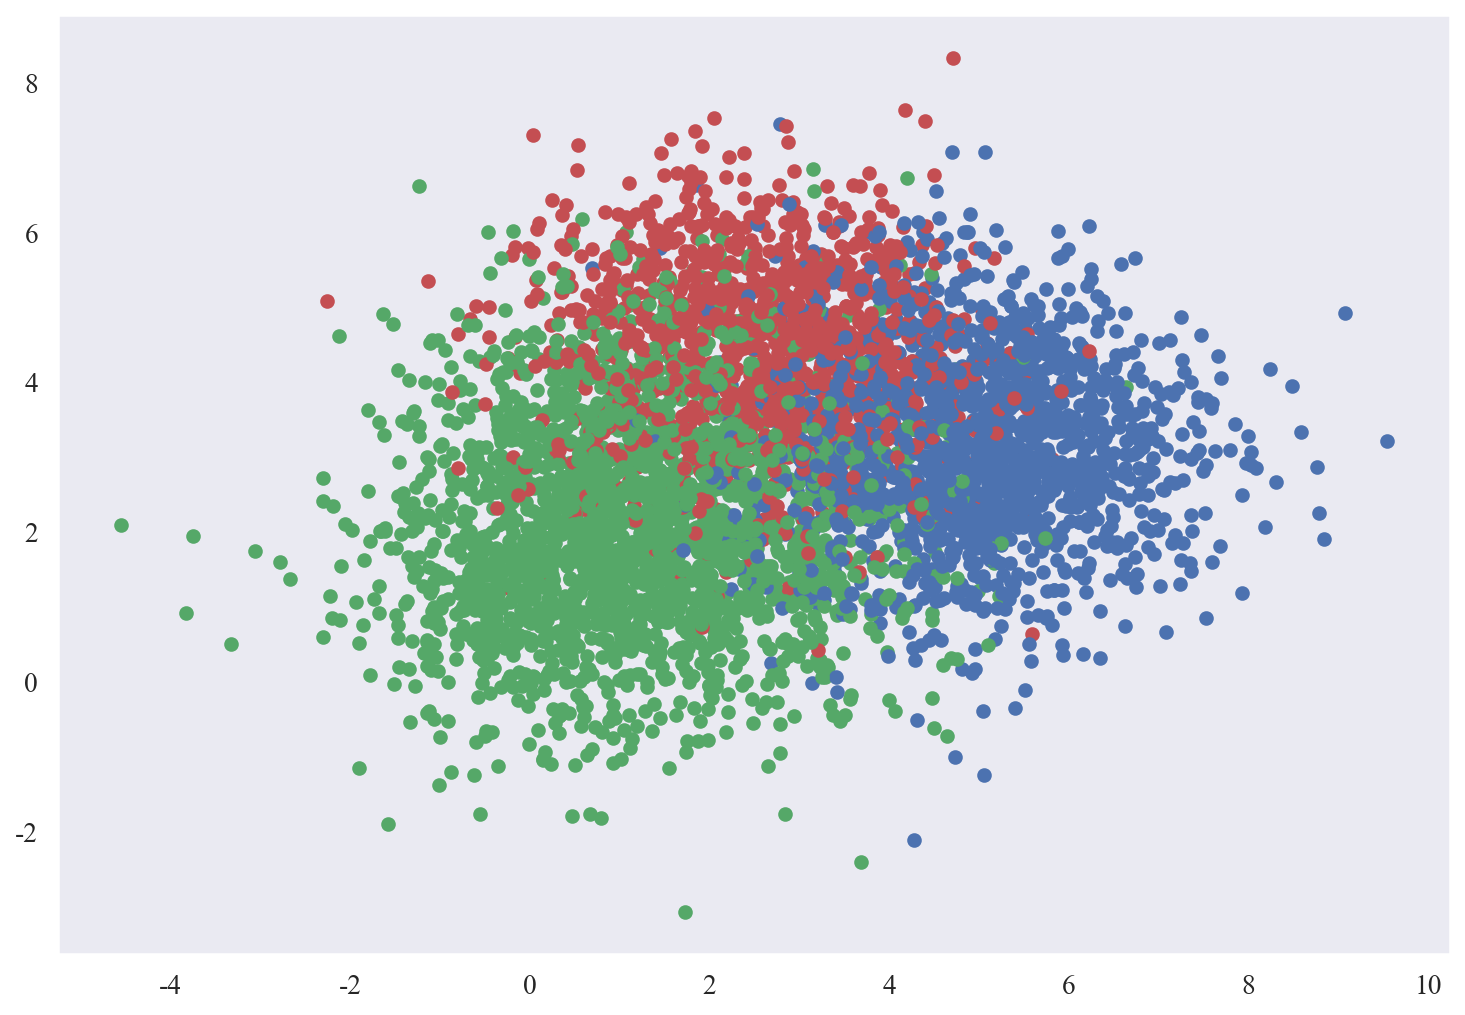

In [49]:
clusterplot(newdata)

## 噪声图像分割

In [13]:
from PIL import Image
import pylab

In [14]:
def image_add_noise(image):
    img = image.astype(np.int16)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(3):
                img[i, j, k] += random.gauss(mu=0, sigma=50)
    img[img > 255] = 255
    img[img < 0] = 0
    img = img.astype(np.uint8)
    return img

In [15]:
img = Image.open('image-1080x1350.jpg')
# img = img.convert('L')
imgdata = image_add_noise(np.array(img))
noiseimg = Image.fromarray(imgdata)
noiseimg.save('noise_image.jpg')

In [16]:
def getImageRGB(file):
    image = Image.open(file)
    image = np.array(image)
    width, height, x = image.shape
    rgb = np.zeros((width, height, x))
    for i in range(width):
        for j in range(height):
            rgb[i][j] = image[i, j]
    return rgb

In [17]:
def initCentroids(imageRGB, k):
    center = []
    for i in range(k):
        x, y = random.randint(0, imageRGB.shape[0]), \
                random.randint(0, imageRGB.shape[1])
        center += [[x, y]]
    return center

In [18]:
def chooseOneNoCenterSample(imageRGB, centers):
    x, y = 0, 0
    isChooseACenterSampleFlag = True
    while(isChooseACenterSampleFlag):
        isExist = False
        x, y = random.randint(0, imageRGB.shape[0]), \
                random.randint(0, imageRGB.shape[1])
        for k in range(len(centers)):
            if(x==centers[k][0] and y==centers[k][1]):
                isExist = True
                break;
        if(isExist == False):
            break;
    return [x, y]

In [19]:
def caclEucDistance(imageRGB, centers):
    region = []
    for i in range(imageRGB.shape[0]):
        x = []
        for j in range(imageRGB.shape[1]):
            temp = []
            for k in range(len(centers)):
                dist = np.sqrt(np.sum(np.square(imageRGB[i, j] 
                    - imageRGB[centers[k][0], centers[k][1]])))
                temp += [dist]
            x.append(np.argmin(temp))
        region.append(x)
    return region

In [20]:
def calcCost(imageRGB, features, centers):
    cost = 0.0
    for i in range(imageRGB.shape[0]):
        for j in range(imageRGB.shape[1]):
            dist = np.sqrt(np.sum(np.square(imageRGB[i, j] 
                            - imageRGB[centers[features[i][j]][0],
                            centers[features[i][j]][1]])))
            cost = cost + dist
    return cost

In [21]:
def showImage(imageRGB, centercolor, features, k, iteration):
    NewImage = np.empty((len(features), len(features[0]), 3))
    for i in range(len(features)):
        for j in range(len(features[i])):
            NewImage[i, j] = centercolor[features[i][j]]
    fig = plt.figure(figsize=(10, 4), facecolor='white')
    fig.suptitle('knum='+str(k)+', iternum='+str(iteration),
                 fontsize=12, color='k')
    fig.gca().xaxis.set_major_locator(plt.NullLocator())
    fig.gca().yaxis.set_major_locator(plt.NullLocator())

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('off')
    ax1.imshow(imageRGB / 255)
    ax1.set_title('Original image', fontsize=10, color='k')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.axis('off')
    ax2.imshow(NewImage / 255)
    ax2.set_title('Split image', fontsize=10, color='k')

    pylab.show()
    plt.savefig('cluster' + str(k) + '.pdf')
    plt.show()

In [22]:
def PAM(imageRGB, features, centers):
    cost0 = calcCost(imageRGB, features, centers)
    aNoCenterSample = chooseOneNoCenterSample(imageRGB, centers)

    belongsK = features[aNoCenterSample[0]][aNoCenterSample[1]]
    TempCenters = centers
    TempCenters[belongsK][0] = aNoCenterSample[0]
    TempCenters[belongsK][1] = aNoCenterSample[1]
    TempFeatures = caclEucDistance(imageRGB, TempCenters)
    Tempcost = calcCost(imageRGB, TempFeatures, TempCenters)
    if (Tempcost < cost0):
        centers = TempCenters
        features = TempFeatures
        cost0 = Tempcost
    return features, centers

In [23]:
def calNewCenter(features, imageRGB, k):
    temp = [] 
    for i in features:
        for j in i:
            temp.append(j)
    centercolor = [0] * k
    for i in range(len(features)): #Rows
        for j in range(len(features[i])): #Columns
            centercolor[features[i][j]] += imageRGB[i, j]
    
    for i in range(len(centercolor)):
        centercolor[i] /= temp.count(i)
        for j in range(len(centercolor[i])):
            centercolor[i][j] = int(centercolor[i][j])
    return centercolor

In [24]:
def main(knum, iternum):
    imageRGB = getImageRGB('noise_image.jpg')
    k = knum
    iteration = iternum
    
    centers = initCentroids(imageRGB, k)
    features = caclEucDistance(imageRGB, centers)
    print('PAM start...\n')
    for i in range(iteration, 0, -1):
        print('iteration = ', i)
        features, centers = PAM(imageRGB, features, centers)
        print('\n' + 'Centers = ', centers, '\n')

    centercolor = calNewCenter(features, imageRGB, k)
    showImage(imageRGB, centercolor, features, k, iteration)

PAM start...

iteration =  5

Centers =  [[1268, 303], [961, 597], [535, 984]] 

iteration =  4

Centers =  [[1268, 303], [575, 982], [535, 984]] 

iteration =  3

Centers =  [[1268, 303], [471, 892], [535, 984]] 

iteration =  2

Centers =  [[1268, 303], [860, 681], [535, 984]] 

iteration =  1

Centers =  [[1268, 303], [860, 681], [1320, 457]] 



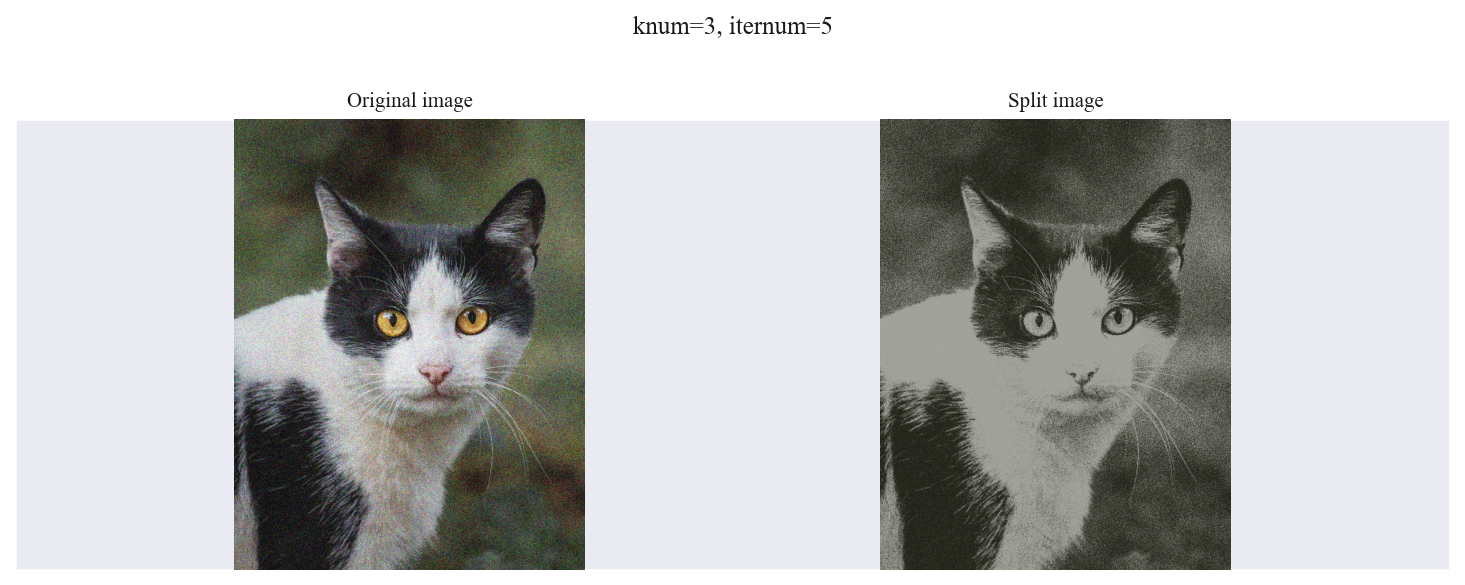

<Figure size 1500x1050 with 0 Axes>

In [25]:
main(3, 5)

PAM start...

iteration =  5

Centers =  [[45, 206], [453, 973], [217, 489], [1041, 446], [887, 151], [504, 764]] 

iteration =  4

Centers =  [[45, 206], [453, 973], [217, 489], [1041, 446], [1116, 507], [504, 764]] 

iteration =  3

Centers =  [[45, 206], [1130, 1031], [217, 489], [1041, 446], [1116, 507], [504, 764]] 

iteration =  2

Centers =  [[45, 206], [1130, 1031], [217, 489], [781, 510], [1116, 507], [504, 764]] 

iteration =  1

Centers =  [[45, 206], [1247, 610], [217, 489], [781, 510], [1116, 507], [504, 764]] 



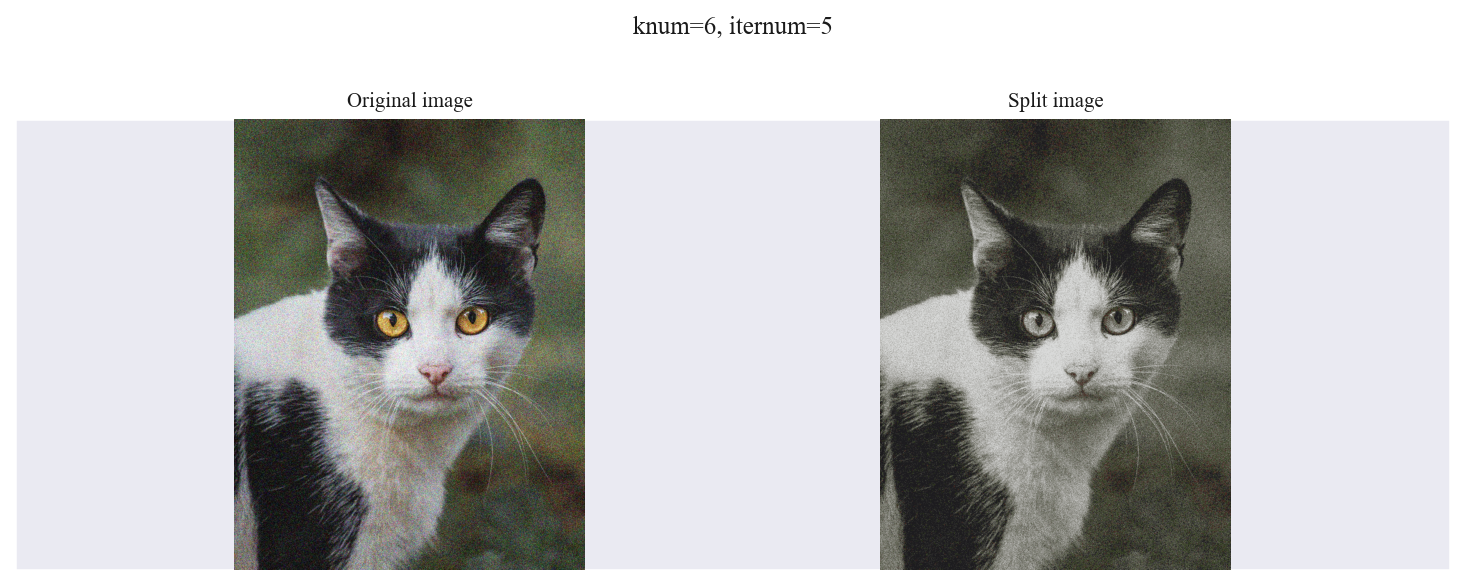

<Figure size 1500x1050 with 0 Axes>

In [26]:
main(6, 5)